In [1]:
import argparse
from functools import partial
from typing import Dict, Optional, Union

import torch
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses.dice import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete
from torch.utils.data import DataLoader

from bts.common import logutils, miscutils
from bts.common.miscutils import DotConfig
from bts.data.dataset import get_train_dataset, get_val_dataset
from bts.swinunetr import model as smodel

In [2]:
logger = logutils.get_logger(__name__)

In [3]:
hyperparams = miscutils.load_hyperparameters("../bts/swinunetr/hyperparameters.yaml")
hyperparams

[:home:vedatb:senior-project:bbm47980_bts:.venv:lib:python3.9:site-packages:miscutils.py:load_hyperparameters:63] Hyperparameters loaded: {'BATCH_SIZE': 2, 'SHUFFLE': True, 'ROI': [128, 128, 128], 'IN_CHANNELS': 1, 'OUT_CHANNELS': 2, 'FEATURE_SIZE': 48, 'GRADIENT_CHECKPOINT': True, 'EPOCHS': 5000, 'FOLD': 1, 'SW_BATCH_SIZE': 2, 'LEARNING_RATE': 0.0001, 'INFER_OVERLAP': 0.6, 'WEIGHT_DECAY': 1e-05, 'DEVICE': 'cuda', 'LABELS': {'GROUND': 0, 'BRAIN': 1, 'TUMOR': 2}}


DotConfig({'BATCH_SIZE': 2, 'SHUFFLE': True, 'ROI': [128, 128, 128], 'IN_CHANNELS': 1, 'OUT_CHANNELS': 2, 'FEATURE_SIZE': 48, 'GRADIENT_CHECKPOINT': True, 'EPOCHS': 5000, 'FOLD': 1, 'SW_BATCH_SIZE': 2, 'LEARNING_RATE': 0.0001, 'INFER_OVERLAP': 0.6, 'WEIGHT_DECAY': 1e-05, 'DEVICE': 'cuda', 'LABELS': DotConfig({'GROUND': 0, 'BRAIN': 1, 'TUMOR': 2})})

In [4]:
hyperparams.BATCH_SIZE = 4

In [5]:
smodel.set_cudnn_benchmark()

[:home:vedatb:senior-project:bbm47980_bts:.venv:lib:python3.9:site-packages:model.py:set_cudnn_benchmark:45] Enabling cuDNN benchmark.


In [6]:
model = smodel.get_model(
    img_size=hyperparams.ROI,
    in_channels=hyperparams.IN_CHANNELS,
    out_channels=hyperparams.OUT_CHANNELS,
    feature_size=hyperparams.FEATURE_SIZE,
    use_checkpoint=hyperparams.GRADIENT_CHECKPOINT,
)

[:home:vedatb:senior-project:bbm47980_bts:.venv:lib:python3.9:site-packages:model.py:get_model:38] SwinUNETR model created.


In [7]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

In [8]:
model = torch.nn.DataParallel(model)

In [9]:
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)

In [10]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=hyperparams.LEARNING_RATE,
    weight_decay=hyperparams.WEIGHT_DECAY,
)

In [11]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=hyperparams.EPOCHS
)

In [12]:
from monai.transforms import (
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Transform,
    RandSpatialCropd,
    RandFlipd,
)

from bts.data import ConvertToMultiChannelBasedOnEchidnaClassesd, JsonTransform
from bts.data.utils import UnsqueezeDatad

from torch.utils.data import DataLoader

import monai

In [13]:
transforms = Compose([
                LoadImaged(["img", "label"], reader="NrrdReader"),
                UnsqueezeDatad(["img"]),
                ConvertToMultiChannelBasedOnEchidnaClassesd(["label"]),
                JsonTransform(["info"]),
                RandSpatialCropd(
                     keys=["img", "label"],
                     roi_size=[128, 128, 128],
                     random_size=False,
                ),
                RandFlipd(keys=["img", "label"], prob=0.5, spatial_axis=0),
                RandFlipd(keys=["img", "label"], prob=0.5, spatial_axis=1),
                RandFlipd(keys=["img", "label"], prob=0.5, spatial_axis=2),
                NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
            ])


In [14]:
from bts.data import EchidnaDataset

btsed_dataset = EchidnaDataset(
    dataset_root_path = "../../data/btsed_dataset",
    transform = transforms
)

data_loader = DataLoader(btsed_dataset, batch_size = hyperparams.BATCH_SIZE)

In [15]:
model = model.to("cuda")
for sample in data_loader:
    img, label, info = sample.get("img"), sample.get("label"), sample.get("info")
    
    img = img.to("cuda")
    label = label.to("cuda")
    pred = model(img)
    
    print(info)
    print(img.shape, pred.shape)
    print(label.shape)
    break

{'patient_name': ['ahmet_timur_label', 'altun_nurten_label', 'cansel_akgun_label', 'elif_ece_altun_label']}
torch.Size([4, 1, 128, 128, 128]) torch.Size([4, 2, 128, 128, 128])
torch.Size([4, 2, 128, 128, 128])


In [16]:
label.shape

torch.Size([4, 2, 128, 128, 128])

In [17]:
pred.shape

torch.Size([4, 2, 128, 128, 128])

In [18]:
dice_loss(target=label, input=pred)

tensor(0.8371, device='cuda:0', grad_fn=<AliasBackward0>)

image shape: torch.Size([128, 128, 128]), label shape: torch.Size([4, 2, 128, 128, 128])


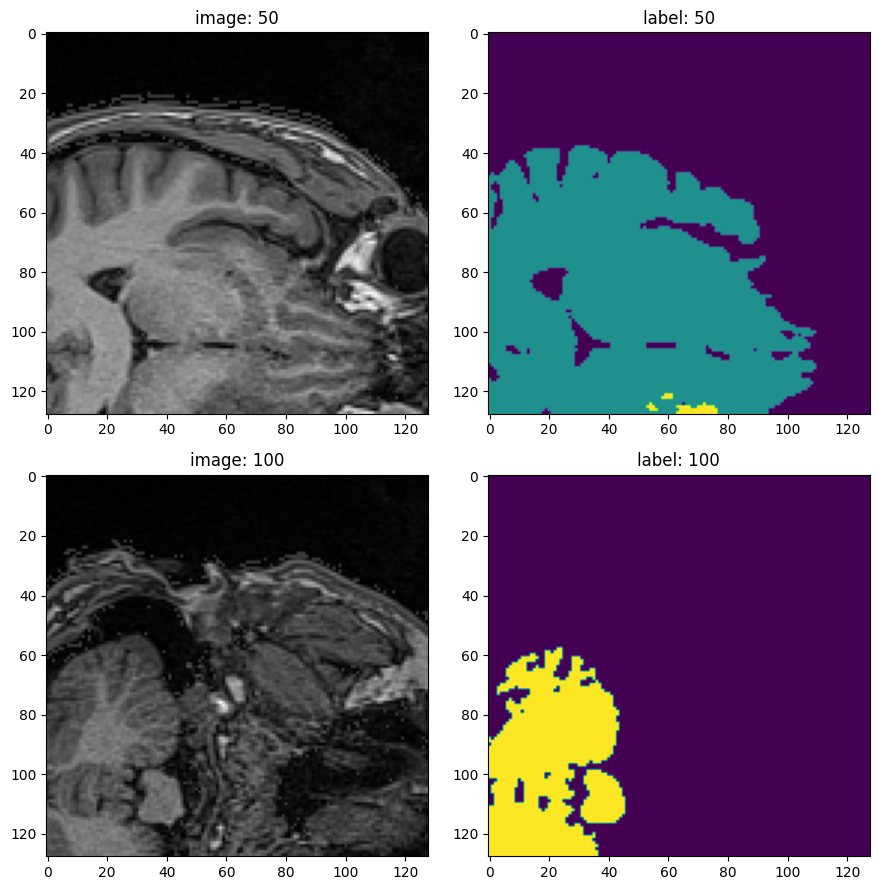

In [19]:
import matplotlib.pyplot as plt

slice_nums = [50, 100]

img = sample["img"][0][0]

label_discrete = (
    (sample["label"][0][0] == 1) * hyperparams.LABELS.BRAIN +
    (sample["label"][0][1] == 1) * hyperparams.LABELS.TUMOR
)

print(f"image shape: {img.shape}, label shape: {label.shape}")
fig, axs = plt.subplots(2, 2, figsize=(9, 9))

slice_num = slice_nums[0]
axs[0, 0].set_title(f"image: {slice_num}")
axs[0, 0].imshow(img[:, :, slice_num], cmap="gray")

axs[0, 1].set_title(f"label: {slice_num}")
axs[0, 1].imshow(label_discrete[:, :, slice_num])

slice_num = slice_nums[1]
axs[1, 0].set_title(f"image: {slice_num}")
axs[1, 0].imshow(img[:, :, slice_num], cmap="gray")


axs[1, 1].set_title(f"label: {slice_num}")
axs[1, 1].imshow(label_discrete[:, :, slice_num])

fig.tight_layout()
plt.show()

In [20]:
post_pred = AsDiscrete(threshold=0.5, dtype="bool")
post_sigmoid = Activations(sigmoid=True)

In [21]:
with torch.no_grad():
    sig = post_pred(post_sigmoid(pred))

In [22]:
sig[0].shape

torch.Size([2, 128, 128, 128])

In [23]:
label[0][0].shape

torch.Size([128, 128, 128])

In [ ]:
print(label[0][hyperparams.LABELS.BRAIN - 1].sum())

In [24]:
print(label[0][hyperparams.LABELS.BRAIN - 1].sum())
print(sig[0][hyperparams.LABELS.BRAIN - 1].sum())

tensor(636326, device='cuda:0')
tensor(679810, device='cuda:0')


In [25]:
print(label[0][hyperparams.LABELS.TUMOR - 1].sum())
print(sig[0][hyperparams.LABELS.TUMOR - 1].sum())

tensor(2029, device='cuda:0')
tensor(568309, device='cuda:0')


In [26]:
from monai.utils.enums import MetricReduction

dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)

In [27]:
device = torch.device("cuda")

In [28]:
dice_acc.reset()
acc_out = dice_acc(y=label[0][None, ...], y_pred=sig[0][None, ...])
print(acc_out)

tensor([[0.5262, 0.0007]], device='cuda:0')


In [29]:
dice_acc.reset()
acc_out = dice_acc(y=label, y_pred=sig)
print(acc_out)

tensor([[0.5262, 0.0007],
        [0.4567,    nan],
        [0.1605,    nan],
        [0.2581,    nan]], device='cuda:0')


In [ ]:
acc_out

In [ ]:
from monai.data import decollate_batch

In [ ]:
acc, not_nans = dice_acc.aggregate()

In [ ]:
acc, not_nans

In [ ]:
run_acc = miscutils.AverageMeter()

In [ ]:
run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())

In [ ]:
run_acc.avg[0]

In [ ]:
run_acc.avg[1]

In [ ]:
run_acc.avg[2]

In [ ]:
!nvidia-smi